<a href="https://colab.research.google.com/github/cosmina98/PhD/blob/main/Work_in_progress/Graph_Sage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [11]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install plotnine --quiet
!pip install torch_geometric
! install torch_geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.12.1+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
install: missing destination file operand after 'torch_geometric'
Try 'install --help' for more information.


In [7]:
import torch_geometric
from torch_geometric.datasets import Planetoid
import os.path as osp

import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

In [ ]:
import torch_geometric 
from typing import Callable, List, Optional, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch import Tensor
from torch.optim import Optimizer
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv,ChebConv
#from torch_geometric.utils import accuracy
from typing_extensions import Literal, TypedDict
from torch_geometric.utils import get_laplacian
import numpy as np
import pandas as pd
from plotnine import ggplot, geom_line, aes, xlab, theme, element_blank, ggtitle
import scipy.sparse as sparse
from sklearn.model_selection import KFold
from torch_geometric.utils import to_scipy_sparse_matrix
from dataclasses import dataclas

In [20]:
# libary imports 
import os
import torch
from torch import nn
import torchvision
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn.metrics import accuracy_score

from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm

import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import matplotlib.pyplot as plt
import numpy as np
import copy
import random
import time
import pandas as pd

import itertools
from functools import reduce
import operator
import torch.utils.data as data_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
from torch.utils.data import Subset

from torch.optim.adadelta import Adadelta
from torch.optim.adagrad import Adagrad
from torch.optim.adam import Adam
from torch.optim.adamax import Adamax
from torch.optim.adamw import AdamW
from torch.optim.optimizer import Optimizer
from torch.optim.sgd import SGD

import torch_geometric 
from typing import Callable, List, Optional, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch import Tensor
from torch.optim import Optimizer
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv,ChebConv
from typing_extensions import Literal, TypedDict
from torch_geometric.utils import get_laplacian
import numpy as np
import pandas as pd
from plotnine import ggplot, geom_line, aes, xlab, theme, element_blank, ggtitle
import scipy.sparse as sparse
from sklearn.model_selection import KFold
from torch_geometric.utils import to_scipy_sparse_matrix
from dataclasses import dataclass
import torch_geometric.utils
#from torch_geometric.utils import accuracy


In [13]:
device = torch.device('cuda' if torch.cuda.is_available()  else 'cpu')


#Dataset imports

In [21]:
dataset=list(range(3))
i=0
for dataset_name in ['Cora','CiteSeer','PubMed']:
    dataset[i] = Planetoid('/tmp/dataset_name', name=dataset_name)
    num_nodes = dataset[i].data.num_nodes
    num_edges = dataset[i].data.num_edges // 2
    train_len = dataset[i][0].train_mask.sum()
    val_len = dataset[i][0].val_mask.sum()
    test_len = dataset[i][0].test_mask.sum()
    other_len = num_nodes - train_len - val_len - test_len
    print(f"Dataset: {dataset[i].name}")
    print(f"Num. nodes: {num_nodes} (train={train_len}, val={val_len}, test={test_len}, other={other_len})")
    print(f"Num. edges: {num_edges}")
    print(f"Num. node features: {dataset[i].num_node_features}")
    print(f"Num. classes: {dataset[i].num_classes}")
    print(f"Dataset len.: {dataset[i].len()}")
    i=i+1
    print(" ")


Dataset: Cora
Num. nodes: 2708 (train=140, val=500, test=1000, other=1068)
Num. edges: 5278
Num. node features: 1433
Num. classes: 7
Dataset len.: 1
 
Dataset: CiteSeer
Num. nodes: 3327 (train=120, val=500, test=1000, other=1707)
Num. edges: 4552
Num. node features: 3703
Num. classes: 6
Dataset len.: 1
 
Dataset: PubMed
Num. nodes: 19717 (train=60, val=500, test=1000, other=18157)
Num. edges: 44324
Num. node features: 500
Num. classes: 3
Dataset len.: 1
 


# Training and testing targets for first dataset

In [31]:
for i in range(1):
    data=dataset[i]
    X_train=data[0].x[data[0].train_mask]
    y_train=data[0].y[data[0].train_mask]
    X_test=data[0].x[data[0].test_mask]
    y_test=data[0].y[data[0].test_mask]
    X_val=data[0].x[data[0].val_mask]
    y_val=data[0].y[data[0].val_mask]

#The model

In [43]:
class Net(torch.nn.Module):
    def __init__(self,
        num_node_features:int,
        num_classes:int):
      
        super(Net, self).__init__()
        self.conv = SAGEConv(num_node_features,
                             num_classes,
                             aggr="max") # max, mean, add ...)

    def forward(self, x:Tensor, edge_index: Tensor):
        x = self.conv(x, edge_index)
        return F.log_softmax(x, dim=1)

      

In [26]:
print(Net(dataset[0].num_node_features, dataset[0].num_classes))
print(Net(dataset[1].num_node_features, dataset[1].num_classes))
print(Net(dataset[2].num_node_features, dataset[2].num_classes))


Net(
  (conv): SAGEConv(1433, 7, aggr=max)
)
Net(
  (conv): SAGEConv(3703, 6, aggr=max)
)
Net(
  (conv): SAGEConv(500, 3, aggr=max)
)


#Train and eval steps

In [37]:
# we reb not using the original implementation of he framework 
# in fact we re using the model provided by Pytorch
LossFn= Callable[[Tensor, Tensor], Tensor]
Stage= Literal["train", "val", "test"]

def train_step(
    model: torch.nn.Module, data:Data, optimizer: torch.optim.Optimizer, loss_fn:LossFn)-> Tuple[float, float]:
    model.train()
    optimizer.zero_grad()
    mask=data.train_mask
    logits=model(data.x, data.edge_index)[mask]
    preds=logits.argmax(dim=1)
    y=data.y[mask]
    loss= loss_fn(logits, y)
    acc=accuracy_score(preds, y)
    loss.backward()
    optimizer.step()
    return loss.item(), acc


@torch.no_grad()
def eval_step(model:torch.nn.Module, data:Data, loss_fn:LossFn, stage:Stage)-> Tuple[float, float]:
    model.eval()
    mask=getattr(data, f"{stage}_mask")
    logits=model(data.x, data.edge_index)[mask]
    preds=logits.argmax(dim=1)
    y=data.y[mask]
    loss=loss_fn(logits, y)
    acc=accuracy_score(preds, y)
    return loss.item(), acc 

In [38]:
class HistoryDict(TypedDict):
    loss: List[float]
    acc: List[float]
    val_loss: List[float]
    val_acc: List[float]

def train(
    model: torch.nn.Module,
    data: Data,
    optimizer: torch.optim.Optimizer,
    loss_fn: LossFn = torch.nn.CrossEntropyLoss(),
    max_epochs: int = 200,
    early_stopping: int = 10,
    print_interval: int = 20,
    verbose: bool = False,
) -> HistoryDict:
    history = {"loss": [], "val_loss": [], "acc": [], "val_acc": [],"test_acc":[],"test_loss":[]}
    for epoch in range(max_epochs):
        loss, acc = train_step(model, data, optimizer, loss_fn)
        val_loss, val_acc = eval_step(model, data, loss_fn, "val")
        history["loss"].append(loss)
        history["acc"].append(acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        # The official implementation in TensorFlow is a little different from what is described in the paper...
        if epoch > early_stopping and val_loss > np.mean(history["val_loss"][-(early_stopping + 1) : -1]):
            if verbose:
                print("\nEarly stopping...")

            break

        if verbose and epoch % print_interval == 0:
            print(f"\nEpoch: {epoch}\n----------")
            print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
            print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")

    test_loss, test_acc = eval_step(model, data, loss_fn, "test")
    if verbose:
        print(f"\nEpoch: {epoch}\n----------")
        print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
        print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")
        print(f" Test loss: {test_loss:.4f} |  Test acc: {test_acc:.4f}")
    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc)
    return history
def plot_history(history: HistoryDict, title: str, font_size: Optional[int] = 14) -> None:
    plt.suptitle(title, fontsize=font_size)
    ax1 = plt.subplot(121)
    ax1.set_title("Loss")
    ax1.plot(history["loss"], label="train")
    ax1.plot(history["val_loss"], label="val")
    plt.xlabel("Epoch")
    ax1.legend()

    ax2 = plt.subplot(122)
    ax2.set_title("Accuracy")
    ax2.plot(history["acc"], label="train")
    ax2.plot(history["val_acc"], label="val")
    plt.xlabel("Epoch")
    ax2.legend()

In [ ]:
SEED = 42
MAX_EPOCHS = 200
LEARNING_RATE = 0.01
WEIGHT_DECAY = 5e-4
EARLY_STOPPING = 10

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Net(dataset[0].num_node_features, dataset[0].num_classes)
data = dataset[0][0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)

model2 = Net(dataset[1].num_node_features, dataset[1].num_classes).to(device)
data2 = dataset[1][0].to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history2 = train(model2, data2, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)

model3 = Net(dataset[2].num_node_features, dataset[2].num_classes).to(device)
data3 = dataset[2][0].to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history3= train(model3, data3, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)

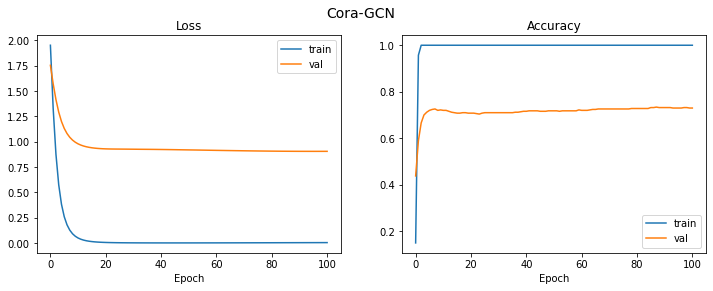

In [45]:
plt.figure(figsize=(12, 4))
plot_history(history, "Cora-GCN")


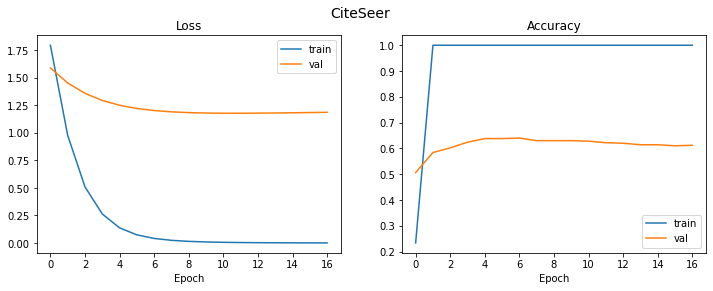

In [48]:
plt.figure(figsize=(12, 4))
plot_history(history2, "CiteSeer")

In [ ]:
plt.figure(figsize=(12, 4))
plot_history(history3, "PubMed")

#Model-Cora -using the default mode

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
      
        super(Net, self).__init__()
        
        self.conv = SAGEConv(data.num_node_features,
                             data.num_classes,
                             aggr="max") # max, mean, add ...)

    def forward(self):
        x = self.conv(data.x, data.edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
data = dataset[0]
print(data[0].edge_index)
model, data = Net().to(device), data[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


In [ ]:
print(model())

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model()[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()


def test():
    model.eval()
    logits, accs = model(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs


In [ ]:
best_val_acc = test_acc = 0
for epoch in range(1,100):
    train()
    _, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log = 'Epoch: {:03d}, Val: {:.4f}, Test: {:.4f}'
    
    if epoch % 10 == 0:
        print(log.format(epoch, best_val_acc, test_acc))

#Model using adaptation

In [90]:
class Net(torch.nn.Module):
    def __init__(self):
      
        super(Net, self).__init__()
        
        self.conv = SAGEConv(data.num_node_features,
                             data.num_classes,
                             aggr="max") # max, mean, add ...)

    def forward(self):
        x = self.conv(data.x, data.edge_index)
        return F.log_softmax(x, dim=1)

In [255]:
class Optimiser(object):
    def __init__(self,classifier,name='Adam',learning_rate=1e-3,  betas=(0.9,0.99) , eps=1e-8, weight_decay=0, amsgrad=False,
      momentum=0.9, nesterov=True, dampening=0, maximize=False,
      rho=0.9,lr_decay=0,initial_accumulator_value=0,capturable=False,
       max_iter=20, max_eval=None, tolerance_grad=1e-07, tolerance_change=1e-09, history_size=100, line_search_fn=None,
       lambd=0.0001, alpha=0.75, t0=1000000.0, momentum_decay=0.004,centered=False,
       etas=(0.5, 1.2), step_sizes=(1e-06, 50)):
          self.learning_rate=learning_rate 
          self.betas= betas
          self.eps= eps
          self.weight_decay=weight_decay
          self.amsgrad=amsgrad 
          self.momentum=momentum
          self.nesterov=nesterov
          self.dampening=dampening
          self.maximize=maximize
          self.classifier=classifier
          self.name=name
          self.optimiser=self.set_optimizer(self.name)
          self.rho=rho
          self.lr_decay=lr_decay
          self.capturable=capturable

          #lbfgs
          self.max_iter=max_iter
          self.max_eval=max_eval
          self.tolerance_grad=tolerance_grad
          self.tolerance_change=tolerance_change
          self.history_size=history_size
          self.line_search_fn=line_search_fn

          #asgd
          self.lambd=lambd
          self.alpha=alpha
          self.t0=t0
          
          #Nadam
          self.momentum_decay=momentum_decay

          self.centered=centered
          self.etas=etas
          self.step_sizes=step_sizes

    def set_optimizer(self, name):
            if name.lower().strip()=='adam':
                        self.optimiser=torch.optim.Adam(self.classifier.parameters(),lr=self.learning_rate, betas=self.betas, eps=self.eps, weight_decay=self.weight_decay, amsgrad=self.amsgrad,maximize=self.maximize)
            elif name.lower().strip()=='sgd':
                        self.optimiser=torch.optim.SGD(self.classifier.parameters(),lr=self.learning_rate, weight_decay=self.weight_decay, momentum=0.9,nesterov=self.nesterov , dampening=self.dampening,maximize=self.maximize)
            elif name.lower().strip()=='adadelta':
                        self.optimiser=torch.optim.Adadelta(self.classifier.parameters(),lr=self.learning_rate, weight_decay=self.weight_decay, eps=self.eps, rho=self.rho,maximize=self.maximize)
            elif name.lower().strip()=='adagrad':
                        self.optimiser=torch.optim.Adagrad(self.classifier.parameters(),lr=self.learning_rate, eps=self.eps, weight_decay=self.weight_decay, maximize=self.maximize,lr_decay=self.lr_decay, initial_accumulator_value=self.initial_accumulator_value)
            elif name.lower().strip()=='adamw':
                        self.optimiser=torch.optim.AdamW(self.classifier.parameters(),lr=self.learning_rate, betas=self.betas, eps=self.eps, weight_decay=self.weight_decay, amsgrad=self.amsgrad,maximize=self.maximize, capturable=self.capturable)
            elif name.lower().strip()=='adamax':
                        self.optimiser=torch.optim.Adamax(self.classifier.parameters(),lr=self.learning_rate, betas=self.betas, eps=self.eps, weight_decay=self.weight_decay,maximize=self.maximize)
            elif name.lower().strip()=='lbfgs':
                        self.optimiser=torch.optim.LBFGS(self.classifier.parameters(),lr=self.learning_rate, max_iter=self.max_iter,max_eval=self.max_eval, tolerance_grad=self.tolerance_grad,tolerance_change=self.tolerance_change, history_size=self.history_size,line_search_fn=self.line_search_fn)
            elif name.lower().strip()=='asgd':
                        self.optimiser=torch.optim.ASGD(self.classifier.parameters(),lr=self.learning_rate, weight_decay=self.weight_decay, lambd=self.lambd, alpha=self.alpha, t0=self.t0 )
            elif name.lower().strip()=='nadam':
                        self.optimiser=torch.optim.NAdam(self.classifier.parameters(),lr=self.learning_rate, weight_decay=self.weight_decay, eps=self.eps, betas=self.betas, momentum_decay=self.momentum_decay)
            elif name.lower().strip()=='radam':
                        self.optimiser=torch.optim.RAdam(self.classifier.parameters(),lr=self.learning_rate, weight_decay=self.weight_decay, eps=self.eps, betas=self.betas )
            elif name.lower().strip()=='rmsprop':
                        self.optimiser=torch.optim.RMSprop(self.classifier.parameters(),lr=self.learning_rate, weight_decay=self.weight_decay, momentum=self.momentum,alpha=self.alpha, eps=self.eps, centered=self.centered)
            elif name.lower().strip()=='rprop':
                        self.optimiser=torch.optim.Rprop(self.classifier.parameters(),lr=self.learning_rate, etas=self.etas, step_sizes=self.step_sizes)
            
            return self.optimiser

In [281]:
class Neural_Network(object):
    
    
    def __init__ (self,classifier=None,batch_size=2000,epochs=2,verbose=True,loss_function = nn.CrossEntropyLoss(),
         optimiser_name='adam'):
      
      self.batch_size=batch_size
      self.epochs=epochs
      
      self.verbose=False
      #used inside the training/ testing loops
      self.running_loss = 0
      self.loss_function = loss_function
      self.classifier= classifier
      self.sm = torch.nn.Softmax()
      self.optimiser_name=optimiser_name
      #default optimiser: adam 
      if classifier != None:
          self.optimiser=Optimiser(name=self.optimiser_name,classifier=self.classifier)
      else:
           self.optimiser=None
    
    def get_params(self): #get parameters
       if (self.optimiser != None) :
         return  (self.props(),self.optimiser.state_dict(), self.classifier.state_dict)
       else: return self.classifier.state_dict() 
  
    def fit(self,X,y):
        train = [*zip(X,y)]
        trainloader =  torch.utils.data.DataLoader(train,batch_size=self.batch_size, shuffle=False, num_workers=2)
        for epoch in range(self.epochs):  # loop over the dataset 2 times
        
          running_loss =self.running_loss
          for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
        
            # zero the parameter gradients
            self.optimiser.optimiser.zero_grad()
            
            # forward + compute loss+ backward + optimize
            outputs = self.classifier(torch.tensor(inputs,dtype=torch.float32))
            #print(outputs)
            if isinstance(self.loss_function,torch.nn.modules.loss.BCELoss):
                labels=torch.tensor(labels,dtype=torch.float32).reshape(-1,1)
            loss = self.loss_function(outputs, labels)
            loss.backward()
            self.optimiser.optimiser.step()
            # print statistics
            running_loss += loss.item()
            if i % self.batch_size == (self.batch_size-1):    # print every "batch_size" mini-batches
                if self.verbose==True:
                  print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / self.batch_size:.3f}')
                running_loss = 0.0

    def predict(self, X_test): #Predict using the multi-layer perceptron classifier.

      if isinstance(X_test, (pd.Series, list, np.ndarray)):
        X_test=(torch.tensor(X_test,  requires_grad = False,dtype=torch.float32))
        outputs = self.classifier(X_test)
        if self.classifier.output_dim==1:
            predictions = torch.round(outputs).detach()
           
        #if we have multi_class classification 
        else:
            log_prob, predictions = torch.max(outputs, 1)
        
        return predictions #torch.stack(prediction_list)
      else:
        with torch.no_grad():
          outputs = self.classifier(X_test)
          if self.classifier.output_dim==1:
            predictions = torch.round(outputs).detach()
          else:
            log_prob, predictions = torch.max(outputs, 1)
          return predictions #torch.stack(prediction_list)


    def predict_log_proba(self,X):  #	Return the log of probability estimates.
        y_prob=(self.predict_proba(X))
        log_proba=np.log(y_prob.detach().numpy())
        return log_proba
 

    def predict_proba(self,X_test):	#Probability estimates.
      probabilities_list=[]
      if isinstance(X_test, (pd.Series, list, np.ndarray)):
        X_test=(torch.tensor(X_test,  requires_grad = False,dtype=torch.float32))
        outputs = self.classifier(X_test)
        predicted=self.sm( outputs) 
        if self.classifier.output_dim==1:
           predicted=outputs
        return predicted
      else:
        with torch.no_grad():
            outputs = self.classifier(X_test)
            predicted=self.sm( outputs) 
            if self.classifier.output_dim==1:
                predicted=outputs
            return  predicted

    def score(self,X_test,y_test): #Return the mean accuracy on the given test data and labels.
        return accuracy_score(y_test, self.predict(X_test).numpy(), sample_weight=None)
        
    def score_per_class(self,X_test,y_test):
      
      if isinstance(X_test, (pd.Series, list, np.ndarray)):
        num_classes=len(torch.unique(torch.tensor(y_test)))
      else:
        num_classes=len(torch.unique((y_test)))
      if (self.classifier.output_dim==1):
        num_classes=2
        
       #Return the mean accuracy on the given test data and labels.
      classes=tuple(np.arange(num_classes))
      correct_pred = {classname: 0 for classname in np.arange(num_classes)}
      total_pred= {classname: 0 for classname in np.arange(num_classes)}
      predictions= self.predict(X_test).numpy()
      if (self.classifier.output_dim==1):
          predictions=predictions.reshape(-1)
      for label, prediction in zip(y_test, predictions):
          if label == prediction:
              correct_pred[classes[label]] += 1
          total_pred[classes[label]] += 1
          accuracies={}
        # print accuracy for each class
      for classname, correct_count in correct_pred.items():
          accuracy = 100 * float(correct_count) / total_pred[classname]
          accuracies[classname]=accuracy
          if self.verbose:
            print(f'Accuracy for class: {classname} is {accuracy:.1f} %')

        

    def set_params(self, attr, value): #sets parameters
        setattr(self, attr, value)
        
    def props(cls):   
        return [i for i in cls.__dict__.items() if i[:1] != '_']


    #def __call__(self):
         #return self.classifier.forward()


In [287]:
data=dataset[0]
model=Neural_Network()
model.classifier=Net(data)
model.epochs=100
model.loss=nn.NLLLoss()
model.optimiser=Optimiser(model.classifier, name='adam', learning_rate=1e-1, weight_decay=5e-4 )


In [284]:
for i in range(1):
    data=dataset[i]
    X_train=data[0].x[data[0].train_mask]
    y_train=data[0].y[data[0].train_mask]
    X_test=data[0].x[data[0].test_mask]
    y_test=data[0].y[data[0].test_mask]
    X_val=data[0].x[data[0].val_mask]
    y_val=data[0].y[data[0].val_mask]

    model=Neural_Network()
    model.classifier=Net(data)
    model.epochs=100
    model.loss=nn.NLLLoss()
    model.optimiser=Optimiser(model.classifier, name='adam', learning_rate=1e-1, weight_decay=5e-4 )
  
    model.fit(X_train, y_train)



tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])


TypeError: ignored

In [296]:
X_train.shape

torch.Size([140, 1433])

In [289]:
data[0].edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [294]:
data[0].edge_index.shape

torch.Size([2, 10556])

In [239]:
len(data[0].train_mask)

2708

In [234]:
r=data[0].x[data[0].train_mask]
r[0].shape

torch.Size([1433])

In [241]:
dataset[0].data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])